In [132]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
import pickle
from elephant.signal_processing import wavelet_transform
from elephant.spectral import welch_psd
from matplotlib.patches import Rectangle
import time
import seaborn as sns
sns.set_theme()

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
output_dir = Path.home() / 'Desktop' / 'disk1' / 'ecephys_data'
cache = EcephysProjectCache.from_warehouse(manifest=output_dir / 'manifest.json')
channel_df = cache.get_channels()
probes_df = cache.get_probes()

# 1) Load session with probes in VISp and VISpm

In [3]:
with open('VISpm_VISp_probes.pkl', 'rb') as f:
    probe_list = pickle.load(f)
print('[session_id, VISpm/VISp_probe_1, VISpm/VISp_probe_2]')
probe_list

[session_id, VISpm/VISp_probe_1, VISpm/VISp_probe_2]


[[719161530, 729445650, 729445652],
 [732592105, 733744647, 733744649],
 [754312389, 756781555, 756781557],
 [750332458, 757904547, 757904550],
 [751348571, 757984818, 757984820],
 [737581020, 757988389, 757988391],
 [756029989, 760640087, 760640090],
 [755434585, 760642624, 760642628],
 [761418226, 768908582, 768908585],
 [742951821, 769322714, 769322716],
 [759883607, 769322789, 769322793],
 [750749662, 769322804, 769322806],
 [760693773, 769322824, 769322827],
 [758798717, 770930071, 770930073],
 [767871931, 773462990, 773462993],
 [771160300, 773621939, 773621942],
 [771990200, 773654726, 773654728],
 [778240327, 792607547, 792607549],
 [786091066, 792623919, 792623921],
 [778998620, 792626844, 792626847],
 [779839471, 792645493, 792645497],
 [791319847, 805008602, 805008604],
 [797828357, 805579738, 805579741],
 [760345702, 810753197, 810753199],
 [715093703, 810755799, 810755801],
 [794812542, 810758779, 810758781],
 [821695405, 822645895, 822645897],
 [831882777, 832810576, 8328

In [4]:
# Loading the selected session and determining which probe is VISpm/VISp
selected_session_list = probe_list[2]

session = cache.get_session_data(selected_session_list[0])

if 'VISpm' in probes_df[probes_df.index==selected_session_list[1]].ecephys_structure_acronyms.item():
    selected_VISpm_probe_id = selected_session_list[1]
    selected_VISp_probe_id = selected_session_list[2]
else:
    selected_VISpm_probe_id = selected_session_list[2]
    selected_VISp_probe_id = selected_session_list[1]

In [5]:
t1 = time.time()
VISpm_lfp = session.get_lfp(selected_VISpm_probe_id)
print(f'LFP data loaded in {time.time()-t1} seconds.')
t1 = time.time()
VISp_lfp = session.get_lfp(selected_VISp_probe_id)
print(f'LFP data loaded in {time.time()-t1} seconds.')
VISp_lfp

LFP data loaded in 22.425435543060303 seconds.
LFP data loaded in 19.9593505859375 seconds.


<xarray.DataArray 'LFP' (time: 12094352, channel: 76)>
array([[-1.3065000e-05, -2.6325000e-05, -2.4179999e-05, ...,
         9.7500003e-07, -9.7500003e-07, -3.5099999e-06],
       [-3.4709999e-05, -4.4264998e-05, -2.8860000e-05, ...,
        -2.1450001e-06,  7.7999999e-07,  8.9699997e-06],
       [-3.5685000e-05, -5.5575001e-05, -4.2119998e-05, ...,
        -1.0140000e-05, -1.8524999e-05,  3.9000000e-07],
       ...,
       [ 1.8915000e-05, -7.8000003e-06, -4.8749998e-06, ...,
        -1.9695000e-05, -1.8915000e-05, -1.9500000e-07],
       [ 3.4904999e-05, -8.3850000e-06,  2.9250000e-06, ...,
        -5.8500000e-06, -1.5989999e-05, -1.3650000e-06],
       [ 1.3260000e-05,  2.0084999e-05,  1.8915000e-05, ...,
        -3.1200000e-06, -8.1899998e-06,  1.9500000e-07]], dtype=float32)
Coordinates:
  * time     (time) float64 3.69 3.691 3.692 ... 9.679e+03 9.679e+03 9.679e+03
  * channel  (channel) int64 850144018 850144026 ... 850144610 850144618

# 2) Get the 100-300-100s times of the relevant (flash) stimulus block

In [6]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,24.556641,84.623391,60.066750,spontaneous,null
1,84.623391,996.618462,911.995071,gabors,0.0
2,996.618462,1285.609911,288.991449,spontaneous,null
3,1285.609911,1584.109256,298.499344,flashes,1.0
4,1584.109256,1585.860751,1.751496,spontaneous,null
5,1585.860751,2185.361519,599.500767,drifting_gratings,2.0
6,2185.361519,2216.387461,31.025943,spontaneous,null
7,2216.387461,2816.889111,600.501650,natural_movie_three,3.0
8,2816.889111,2846.914201,30.025090,spontaneous,null
9,2846.914201,3147.165021,300.250820,natural_movie_one,4.0


In [7]:
flash_index = stim_epochs[stim_epochs.stimulus_name=='flashes'].index.item()

print('No stimulus block before flashes:')
print(stim_epochs[stim_epochs.index==flash_index-1])
print('\nFlashes block:')
print(stim_epochs[stim_epochs.index==flash_index])
print('\nNo stimulus block after flashes:')
print(stim_epochs[stim_epochs.index==flash_index+1])

No stimulus block before flashes:
   start_time    stop_time    duration stimulus_name stimulus_block
2  996.618462  1285.609911  288.991449   spontaneous           null

Flashes block:
    start_time    stop_time    duration stimulus_name stimulus_block
3  1285.609911  1584.109256  298.499344       flashes            1.0

No stimulus block after flashes:
    start_time    stop_time  duration stimulus_name stimulus_block
4  1584.109256  1585.860751  1.751496   spontaneous           null


In [8]:
global_start_time = stim_epochs[stim_epochs.index==flash_index-1].start_time.item()
global_end_time = stim_epochs[stim_epochs.index==flash_index+1].stop_time.item()

spontaneous_before_start_time = global_start_time
spontaneous_before_end_time = stim_epochs[stim_epochs.index==flash_index-1].stop_time.item()

flashes_start_time = stim_epochs[stim_epochs.index==flash_index].start_time.item()
flashes_end_time = stim_epochs[stim_epochs.index==flash_index].stop_time.item()

spontaneous_after_start_time = stim_epochs[stim_epochs.index==flash_index+1].start_time.item()
spontaneous_after_end_time = global_end_time

print(f'Looking at {global_start_time}s - {global_end_time}s time range')

Looking at 996.6184617712394s - 1585.8607512503477s time range


# 3) Select channels from VISp and VISpm only, select time range defined above only

In [9]:
# Quality check for channels that are in the LFP NWB file but not in the Allen cache
for ch in VISpm_lfp.channel.values:
    if ch not in channel_df.index.to_list():
        VISpm_lfp = VISpm_lfp.drop_sel(channel=ch)
for ch in VISp_lfp.channel.values:
    if ch not in channel_df.index.to_list():
        VISp_lfp = VISp_lfp.drop_sel(channel=ch)

In [10]:
def get_every_area_channel_id_dict(merged_df):
    probe_every_area_channel_ids = {}
    for area in merged_df.ecephys_structure_acronym.unique():
        if pd.isnull(area): # to select NaN area key
            probe_every_area_channel_ids['NaN'] = merged_df[pd.isna(merged_df.ecephys_structure_acronym)].index.to_list()  # works for selecting channels from the NaN area
        else:
            probe_every_area_channel_ids[area] = merged_df[merged_df.ecephys_structure_acronym==area].index.to_list()
    return probe_every_area_channel_ids

In [11]:
# Organise all channels into a dictionary with keys as area names and values as lists with related LFP recording channels
VISpm_cache_channel_df_merged = channel_df.loc[VISpm_lfp.channel.values]
VISp_cache_channel_df_merged = channel_df.loc[VISp_lfp.channel.values]

VISpm_probe_every_area_channel_ids = get_every_area_channel_id_dict(VISpm_cache_channel_df_merged)
VISp_probe_every_area_channel_ids = get_every_area_channel_id_dict(VISp_cache_channel_df_merged)

# VISpm_channel_ids = [ch for ch in VISpm_lfp.channel.values if channel_df[channel_df.index==ch]['ecephys_structure_acronym'].item()=='VISpm']
# VISp_channel_ids = [ch for ch in VISp_lfp.channel.values if channel_df[channel_df.index==ch]['ecephys_structure_acronym'].item()=='VISp']

VISpm_channel_ids = VISpm_probe_every_area_channel_ids['VISpm']
VISp_channel_ids = VISp_probe_every_area_channel_ids['VISp']

print(f'VISpm channels = {len(VISpm_channel_ids)}')
print(f'VISp channels = {len(VISp_channel_ids)}')

VISpm channels = 21
VISp channels = 23


In [12]:
VISpm_lfp_slice = VISpm_lfp.sel(time=slice(global_start_time, global_end_time))
VISp_lfp_slice = VISp_lfp.sel(time=slice(global_start_time, global_end_time))

# 4) Plot the LFP signal from all channels from VISp and VISpm side by side. Choose channel with maximum signal

In [13]:
def get_max_channel_id(data):
    max_amplitudes = np.max(np.abs(data), axis=0)
    return int(np.argmax(max_amplitudes.data))

def get_max_channel_id_list(data):
    max_amplitudes = np.max(np.abs(data), axis=0)
    return np.argsort(-max_amplitudes).data

In [14]:
# For each area in the two probes, determine max amplitude channel/s
VISpm_probe_every_area_max_channel = {}
VISpm_probe_every_area_max_channel_list = {}
VISp_probe_every_area_max_channel = {}
VISp_probe_every_area_max_channel_list = {}

for area, ch_ids in VISpm_probe_every_area_channel_ids.items():
    VISpm_probe_every_area_max_channel[area] = ch_ids[get_max_channel_id(VISpm_lfp_slice.sel(channel=slice(ch_ids[0], ch_ids[-1])))]
    VISpm_probe_every_area_max_channel_list[area] = get_max_channel_id_list(VISpm_lfp_slice.sel(channel=slice(ch_ids[0], ch_ids[-1])))
for area, ch_ids in VISp_probe_every_area_channel_ids.items():
    VISp_probe_every_area_max_channel[area] = ch_ids[get_max_channel_id(VISp_lfp_slice.sel(channel=slice(ch_ids[0], ch_ids[-1])))]
    VISp_probe_every_area_max_channel_list[area] = get_max_channel_id_list(VISp_lfp_slice.sel(channel=slice(ch_ids[0], ch_ids[-1])))

VISpm_max_channel = VISpm_probe_every_area_max_channel['VISpm']
VISpm_max_channel_list = VISpm_probe_every_area_max_channel_list['VISpm']
VISp_max_channel = VISp_probe_every_area_max_channel['VISp']
VISp_max_channel_list = VISp_probe_every_area_max_channel_list['VISp']

print(f'VISpm_max_channel = {VISpm_max_channel}')
print(f'VISp_max_channel = {VISp_max_channel}')

VISpm_max_channel = 850143254
VISp_max_channel = 850144466


In [15]:
VISp_channel_ids[VISp_max_channel_list[0]]

850144466

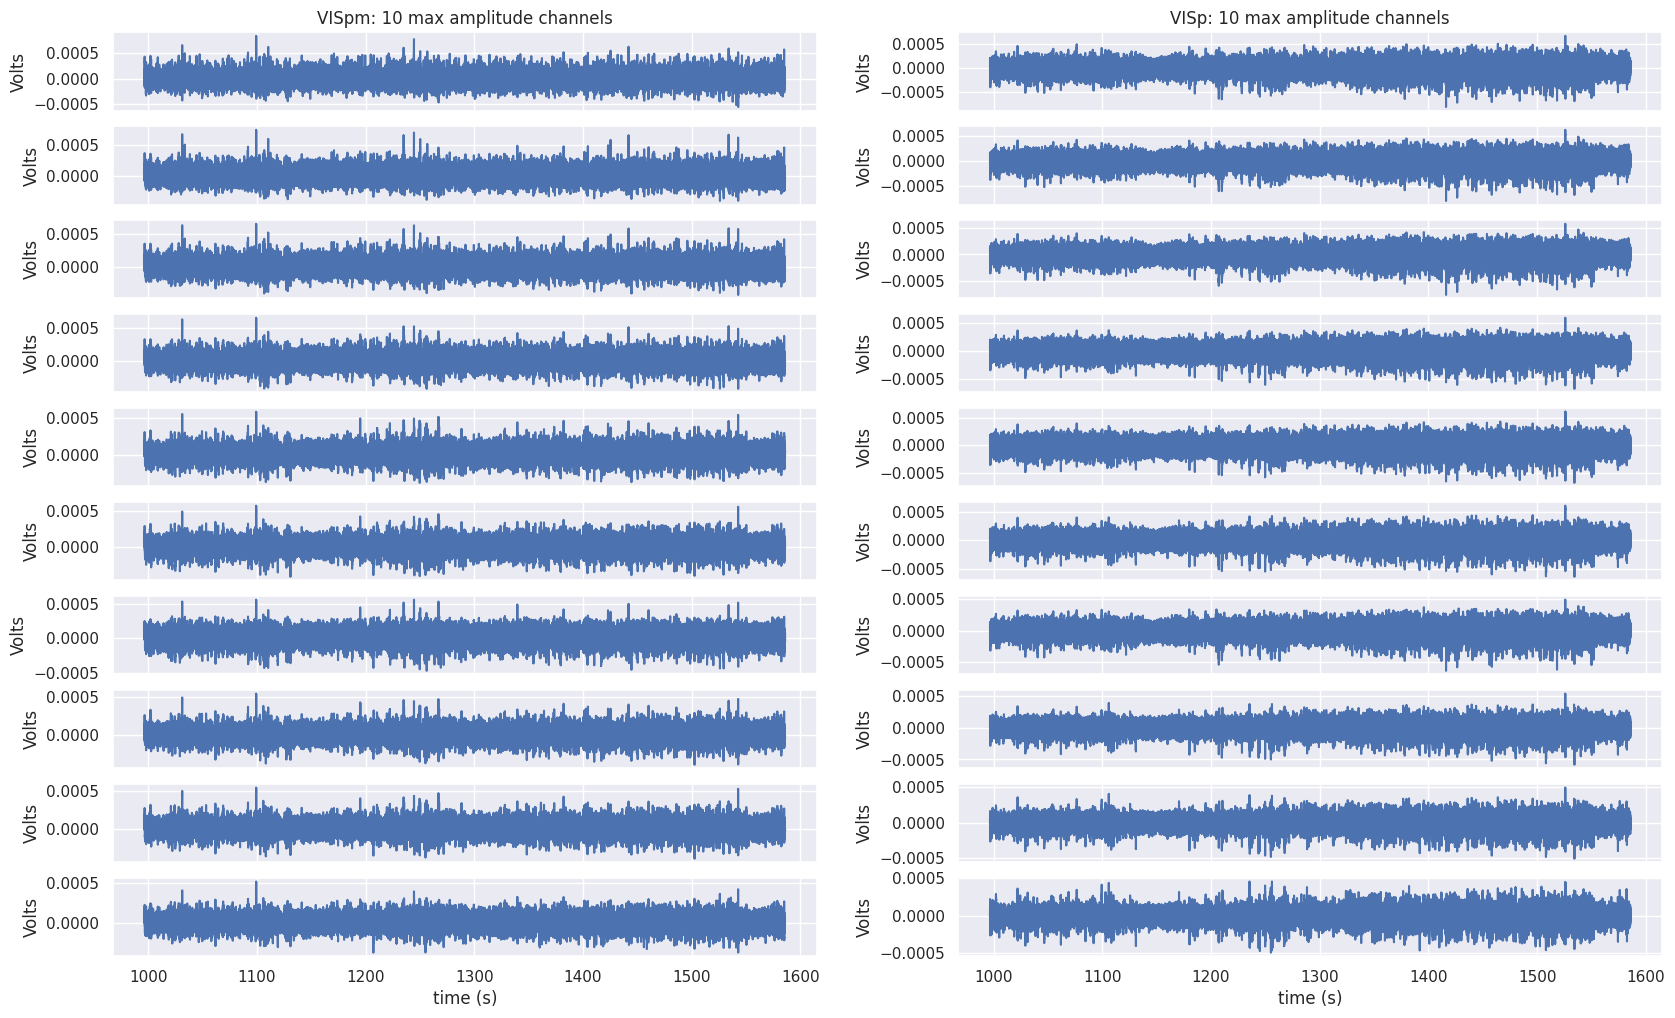

In [16]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(20, 12), sharex=True)
for i in range(10):
    axes[i][0].plot(VISpm_lfp_slice.time, VISpm_lfp_slice.sel(channel=VISpm_channel_ids[VISpm_max_channel_list[i]]))
    axes[i][0].set_ylabel(f'Volts')
axes[i][0].set_xlabel('time (s)')
axes[0][0].set_title('VISpm: 10 max amplitude channels')

for i in range(10):
    axes[i][1].plot(VISp_lfp_slice.time, VISp_lfp_slice.sel(channel=VISp_channel_ids[VISp_max_channel_list[i]]))
    axes[i][1].set_ylabel(f'Volts')
axes[i][1].set_xlabel('time (s)')
axes[0][1].set_title('VISp: 10 max amplitude channels')


plt.show()

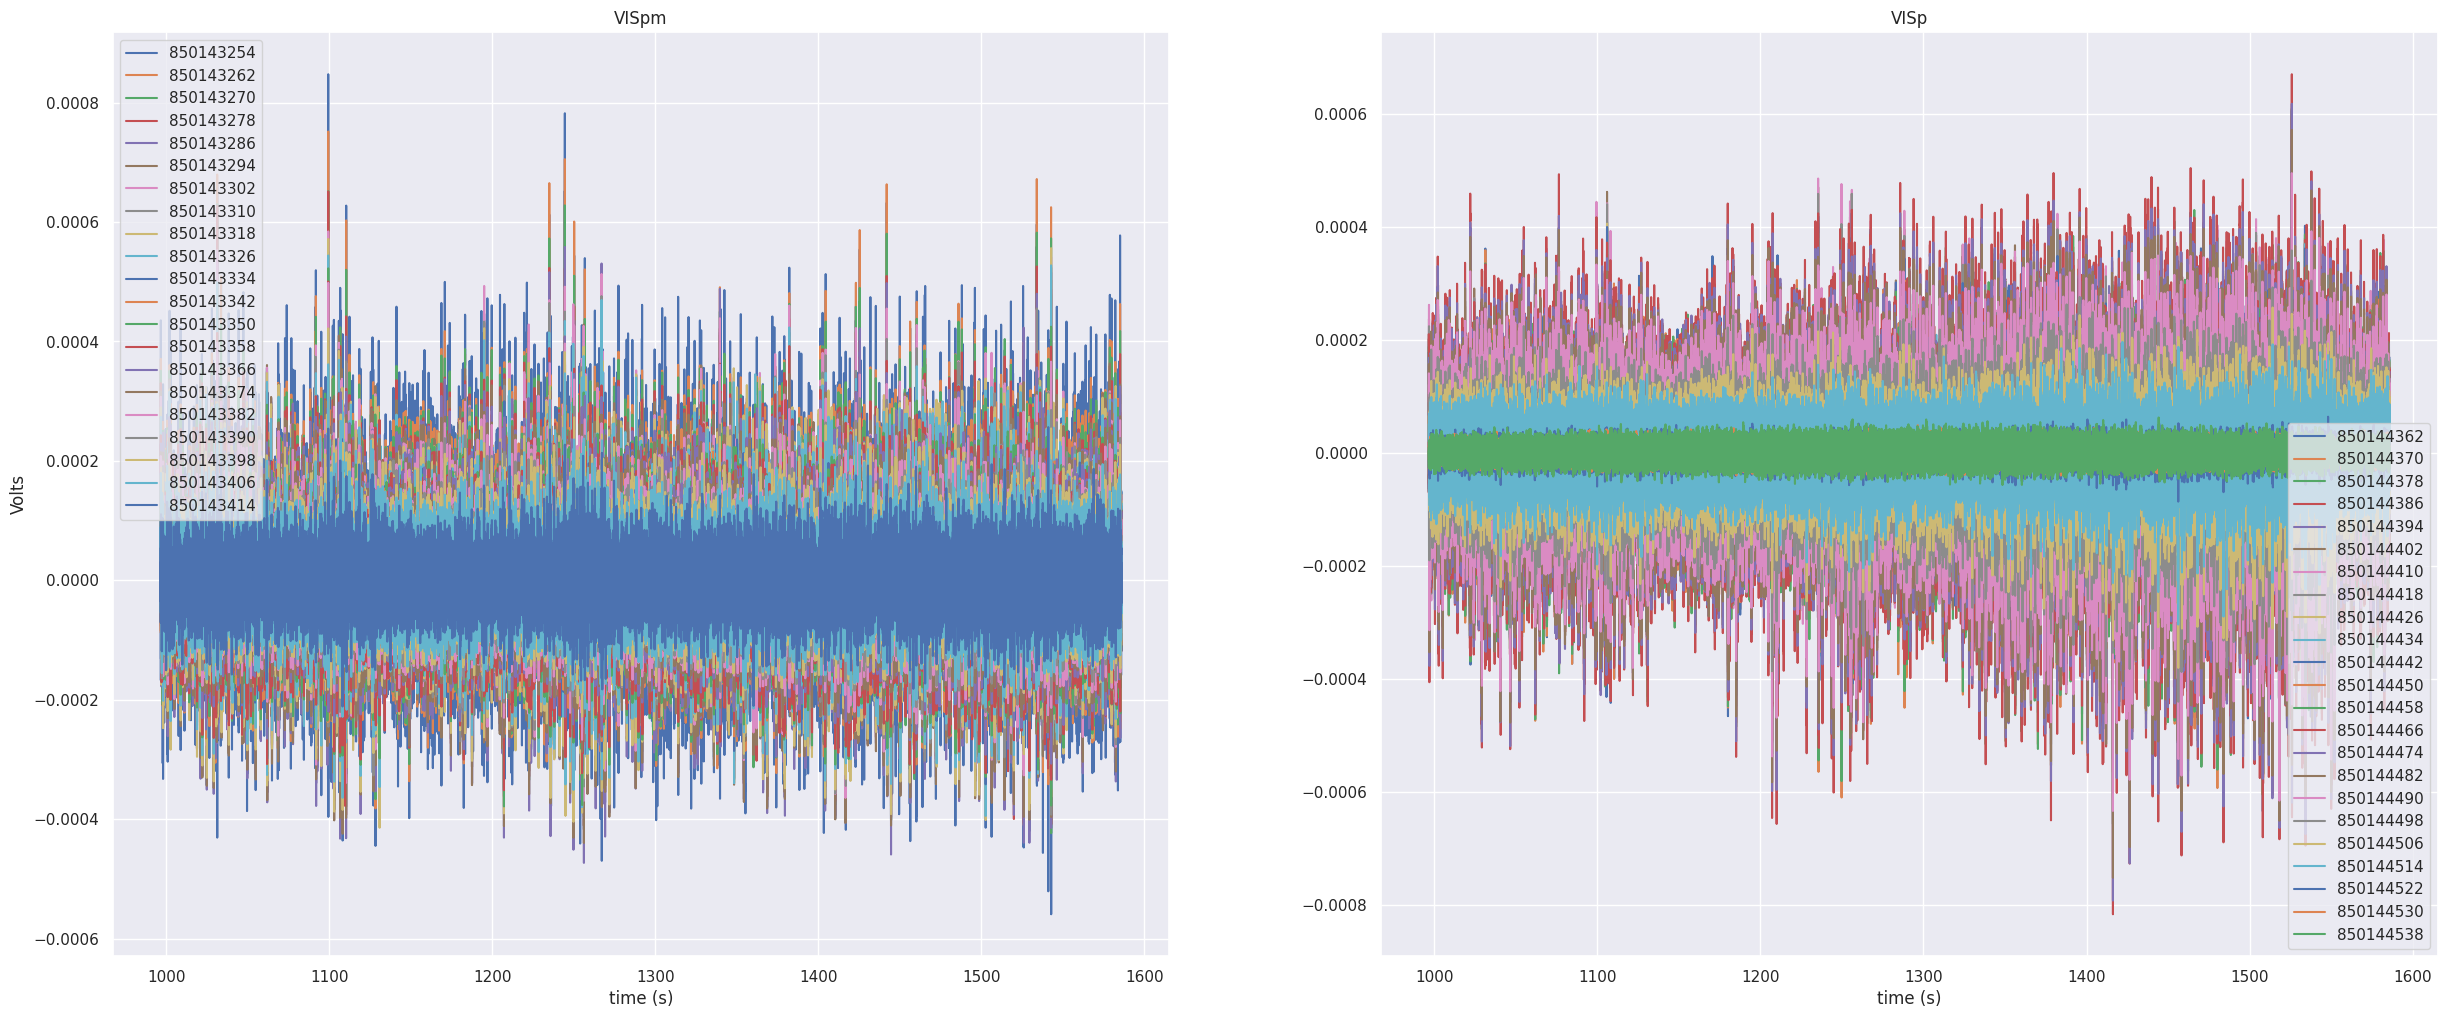

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12), sharex=True)
for i in range(len(VISpm_channel_ids)):
    axes[0].plot(VISpm_lfp_slice.time, VISpm_lfp_slice.sel(channel=VISpm_channel_ids[i]))
axes[0].set_ylabel(f'Volts')
axes[0].set_xlabel('time (s)')
axes[0].legend(VISpm_channel_ids)
axes[0].set_title('VISpm')

for i in range(len(VISp_channel_ids)):
    axes[1].plot(VISp_lfp_slice.time, VISp_lfp_slice.sel(channel=VISp_channel_ids[i]))
axes[1].set_xlabel('time (s)')
axes[1].legend(VISp_channel_ids)
axes[1].set_title('VISp')

plt.show()

# 5) Compute spectrogram from that channel

In [18]:
# Wavelet Transform Parameters
fs = 1250
MAX_FREQUENCY = 100
SPACING_BETWEEN_FREQUENCIES = 0.1
LOAD_WT_DATA = False
DATA_SAVE_PATH = Path.home() / 'Desktop' / 'disk2'

In [19]:
def get_freq_list(MAX_FREQUENCY,SPACING_BETWEEN_FREQUENCIES):
    freq_list = np.arange(0,MAX_FREQUENCY+SPACING_BETWEEN_FREQUENCIES,SPACING_BETWEEN_FREQUENCIES)
    print('Frequency list shape:',freq_list.shape)
    print('First five frequencies:',freq_list[:5])
    print('Last five frequencies:',freq_list[-5:])
    return freq_list

In [20]:
VISpm_filename = f'VISpm_wtData_session_{selected_session_list[0]}_probeID_{selected_VISpm_probe_id}_samplingFreq_{fs}_maxFreq_{MAX_FREQUENCY}_frequencySpacing_{SPACING_BETWEEN_FREQUENCIES}.pkl'
VISp_filename = f'VISp_wtData_session_{selected_session_list[0]}_probeID_{selected_VISp_probe_id}_samplingFreq_{fs}_maxFreq_{MAX_FREQUENCY}_frequencySpacing_{SPACING_BETWEEN_FREQUENCIES}.pkl'

freq_list = get_freq_list(MAX_FREQUENCY,SPACING_BETWEEN_FREQUENCIES)

if LOAD_WT_DATA:
    with open(DATA_SAVE_PATH/VISpm_filename, 'rb') as f:
        VISpm_wt_data = pickle.load(f)
    with open(DATA_SAVE_PATH/VISp_filename, 'rb') as f:
        VISp_wt_data = pickle.load(f)
else:    
    t1 = time.time()
    VISpm_wt_data = wavelet_transform(VISpm_lfp_slice.sel(channel=VISpm_max_channel), frequency=freq_list, sampling_frequency=fs)
    print(f'Morlet transform computed in {time.time() - t1} seconds')
    t1 = time.time()
    VISp_wt_data = wavelet_transform(VISp_lfp_slice.sel(channel=VISp_max_channel), frequency=freq_list, sampling_frequency=fs)
    print(f'Morlet transform computed in {time.time() - t1} seconds')
    
    with open(DATA_SAVE_PATH/VISpm_filename, 'wb') as f:
        pickle.dump(VISpm_wt_data, f, protocol=4)
    with open(DATA_SAVE_PATH/VISp_filename, 'wb') as f:
        pickle.dump(VISp_wt_data, f, protocol=4)
    print('Saved into pickle files')

Frequency list shape: (1001,)
First five frequencies: [0.  0.1 0.2 0.3 0.4]
Last five frequencies: [ 99.6  99.7  99.8  99.9 100. ]


/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/elephant/signal_processing.py:674: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = n_cycles / (6. * freq)
/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/elephant/signal_processing.py:678: RuntimeWarning: invalid value encountered in double_scalars
  -2 * (np.pi * sigma * (freqs - freq)) ** 2) * heaviside * fs
/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/elephant/signal_processing.py:678: RuntimeWarning: invalid value encountered in multiply
  -2 * (np.pi * sigma * (freqs - freq)) ** 2) * heaviside * fs


Morlet transform computed in 59.02054190635681 seconds
Morlet transform computed in 73.68866729736328 seconds
Saved into pickle files


In [21]:
# Plotting Parameters
X_TICKS_NUMBER = 10
Y_TICKS_NUMBER = 10
X_LIM = [0,10e5]
Y_LIM = [0,50]

In [159]:
def get_index_of_highest_below_value(arr, value):
    mask = arr < value  # Create a boolean mask of values below the specific value
    indices = np.where(mask)  # Get the indices where the mask is True
    if indices[0].size > 0: return indices[0][np.argmax(arr[mask])]  # Return the index with the highest value
    else: return 0  # Return None if no values are below the specific value

def get_index_of_lowest_above_value(arr, value):
    mask = arr > value  # Create a boolean mask of values below the specific value
    indices = np.where(mask)  # Get the indices where the mask is True
    if indices[0].size > 0: return indices[0][np.argmin(arr[mask])]  # Return the index with the highest value
    else: return arr.shape[0]-1  # Return None if no values are below the specific value

def plot_wt(wt_data,lfp_slice,title):
    # Refresh frequency list (to avoid breaking if plotting in rerun)
    freq_list = get_freq_list(MAX_FREQUENCY,SPACING_BETWEEN_FREQUENCIES)

    # Apply x-axis limits to the ticks
    x_ticks_list = lfp_slice.time.data
    t1 = get_index_of_highest_below_value(x_ticks_list,X_LIM[0])
    t2 = get_index_of_lowest_above_value(x_ticks_list,X_LIM[1])
    x_ticks_list = x_ticks_list[t1:t2]

    # Apply y-axis limits to frequency list
    f1 = get_index_of_highest_below_value(freq_list,Y_LIM[0])
    f2 = get_index_of_lowest_above_value(freq_list,Y_LIM[1])
    freq_list = freq_list[f1:f2]

    print(f'number of y ticks ({np.arange(0, len(freq_list)+freq_list.shape[0]/Y_TICKS_NUMBER, freq_list.shape[0]/Y_TICKS_NUMBER).shape[0]}) == number of y tick labels ({np.arange(Y_LIM[0],Y_LIM[1]+(Y_LIM[1]-Y_LIM[0])/Y_TICKS_NUMBER,(Y_LIM[1]-Y_LIM[0])/Y_TICKS_NUMBER).shape[0]})')

    # Plot the data with appropriate limits
    fig,ax = plt.subplots(figsize=(20,8))
    im = ax.imshow(np.abs(wt_data)[f1:f2,t1:t2],aspect='auto',origin='lower')

    # Set the values of ticks
    ax.set_xticks(np.linspace(0,wt_data[f1:f2,t1:t2].shape[1],num=X_TICKS_NUMBER))
    ax.set_xticklabels(np.linspace(x_ticks_list[0],x_ticks_list[-1], num=X_TICKS_NUMBER).astype(int))
    ax.set_yticks(np.arange(0, len(freq_list)+freq_list.shape[0]/Y_TICKS_NUMBER, freq_list.shape[0]/Y_TICKS_NUMBER))
    ax.set_yticklabels(np.arange(Y_LIM[0],Y_LIM[1]+(Y_LIM[1]-Y_LIM[0])/Y_TICKS_NUMBER,(Y_LIM[1]-Y_LIM[0])/Y_TICKS_NUMBER))

    ax.set_xlabel("time (s)", fontsize=15)
    ax.set_ylabel("frequency (Hz)", fontsize=15)

    ax.set_title(title)

    fig.colorbar(im, fraction=0.036, pad=0.04)
    
    # Plot transparent rectangle over the flash stimulus presentation block
    rect_t1 = get_index_of_highest_below_value(x_ticks_list,flashes_start_time)
    rect_t2 = get_index_of_lowest_above_value(x_ticks_list,flashes_end_time)
    ax.add_patch(Rectangle((rect_t1,f1),rect_t2-rect_t1,f2-f1,edgecolor='red',facecolor='none'))

    plt.show()

Frequency list shape: (1001,)
First five frequencies: [0.  0.1 0.2 0.3 0.4]
Last five frequencies: [ 99.6  99.7  99.8  99.9 100. ]
number of y ticks (11) == number of y tick labels (11)


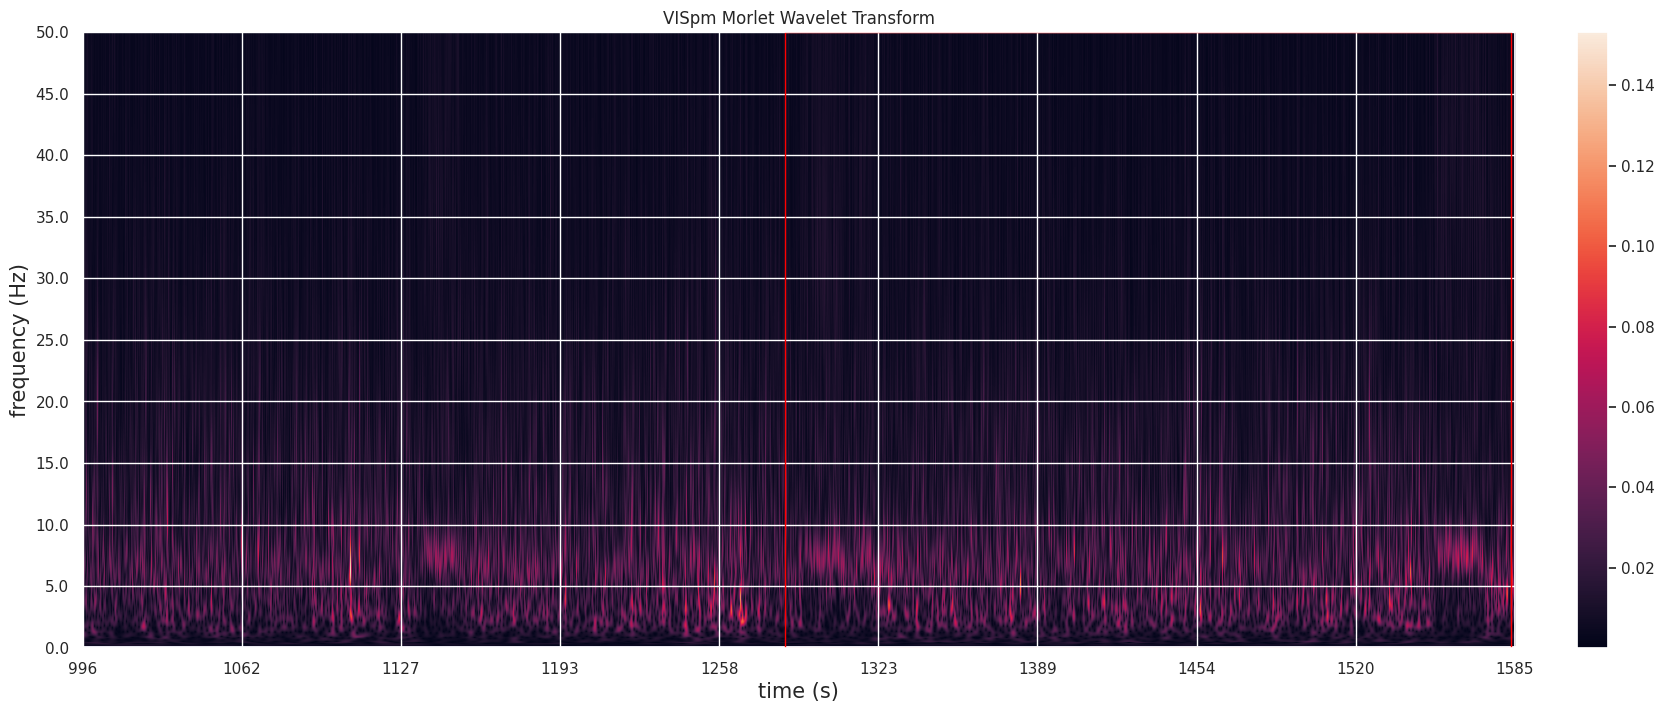

In [161]:
plot_wt(VISpm_wt_data,VISpm_lfp_slice,'VISpm Morlet Wavelet Transform')

Frequency list shape: (1001,)
First five frequencies: [0.  0.1 0.2 0.3 0.4]
Last five frequencies: [ 99.6  99.7  99.8  99.9 100. ]
number of y ticks (11) == number of y tick labels (11)


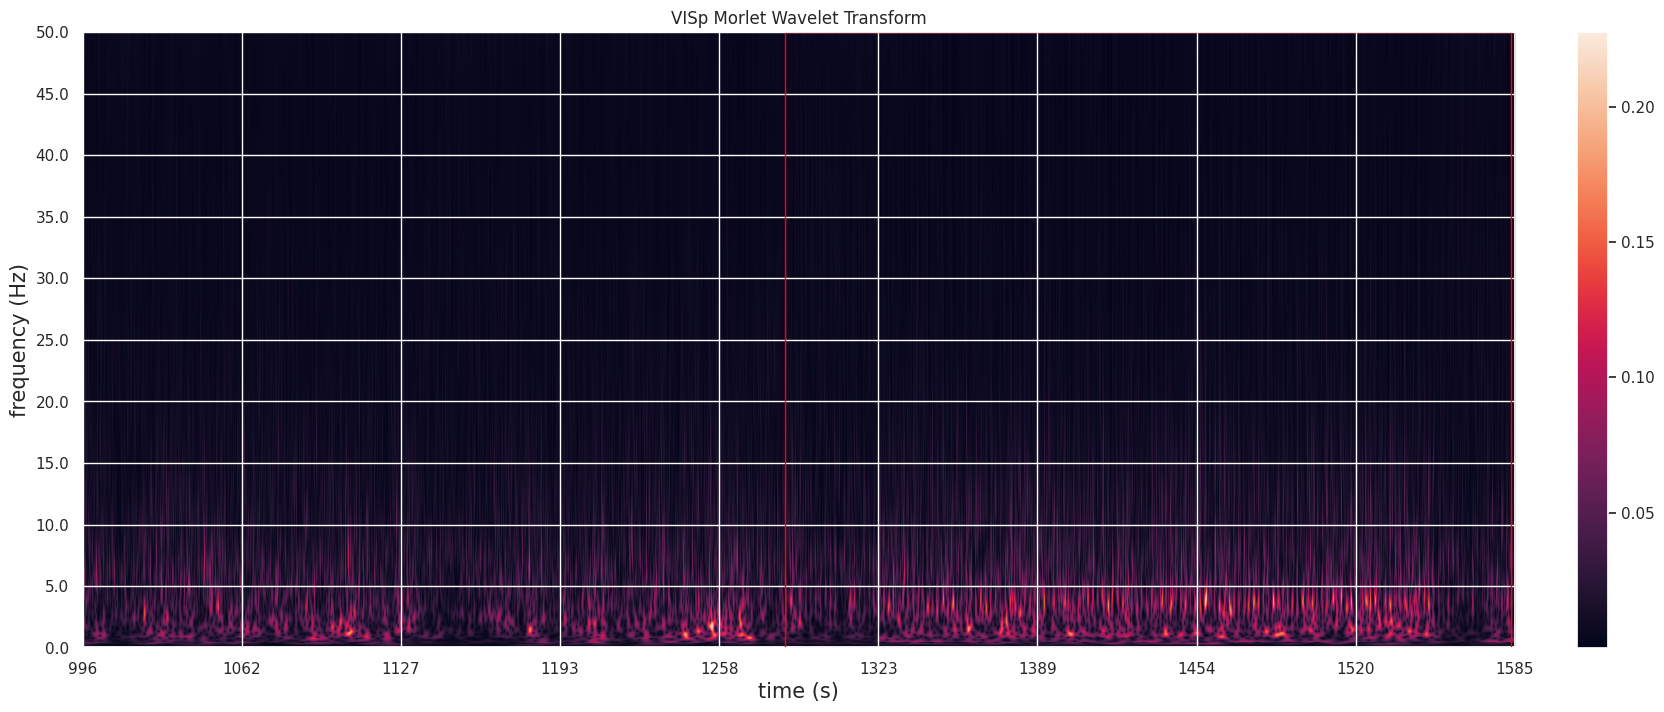

In [162]:
plot_wt(VISp_wt_data,VISp_lfp_slice,'VISp Morlet Wavelet Transform')

# 6) Compute binned PSD from that channel for the three (100-300-100) segments. 0-10Hz, 0.5Hz binning

In [110]:
def welch_psd_plot(ax,lfp_slice,max_channel,title,freq_res=None,xlim=[0,20]):
    f1, psd1 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(spontaneous_before_start_time, spontaneous_before_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)
    f2, psd2 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(flashes_start_time, flashes_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)
    # f3, psd3 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(spontaneous_after_start_time, spontaneous_after_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)

    # plt.semilogy(f, psd)

    ax.plot(f1,psd1)
    ax.plot(f2,psd2)
    # ax.plot(f3,psd3)
    # ax.legend(['Spontaneous Before','Flashes','Spontaneous After'])
    ax.legend(['Spontaneous Before','Flashes'])
    ax.set_xlim(xlim)
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('power (V**2/Hz)')
    ax.set_title(title)

In [111]:
max_channel = VISpm_probe_every_area_max_channel['VISpm']
f1, psd1 = welch_psd(VISpm_lfp_slice.sel(channel=max_channel).sel(time=slice(spontaneous_before_start_time, spontaneous_before_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=0.5)
print(f1)
print(psd1)

[0.000e+00 5.000e-01 1.000e+00 ... 6.240e+02 6.245e+02 6.250e+02]
[2.0508798e-11 6.9621600e-11 1.7410126e-10 ... 5.0787168e-15 5.2669949e-15
 2.4448158e-15]


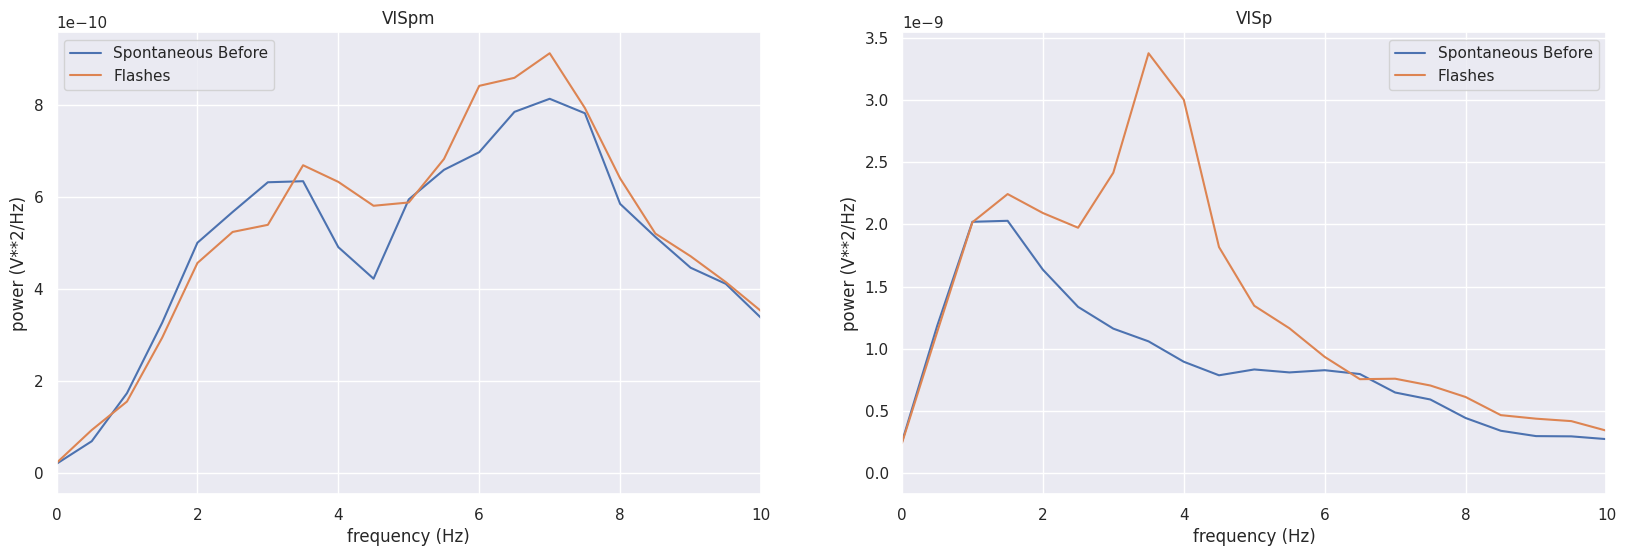

In [113]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

welch_psd_plot(ax1,VISpm_lfp_slice,VISpm_probe_every_area_max_channel['VISpm'],'VISpm',freq_res=0.5,xlim=[0,10])

welch_psd_plot(ax2,VISp_lfp_slice,VISp_probe_every_area_max_channel['VISp'],'VISp',freq_res=0.5,xlim=[0,10])

# plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')


# 7) For other areas recorded in VISp and VISpm probes, repeat Step 6

In [28]:
VISpm_other_areas = list(VISpm_probe_every_area_max_channel.keys())
VISp_other_areas = list(VISp_probe_every_area_max_channel.keys())

VISpm_other_areas.remove('VISpm')
VISp_other_areas.remove('VISp')

print(VISpm_other_areas)
print(VISp_other_areas)

['LGd', 'DG', 'CA3', 'CA1', 'NaN']
['LGd', 'DG', 'CA1', 'NaN']


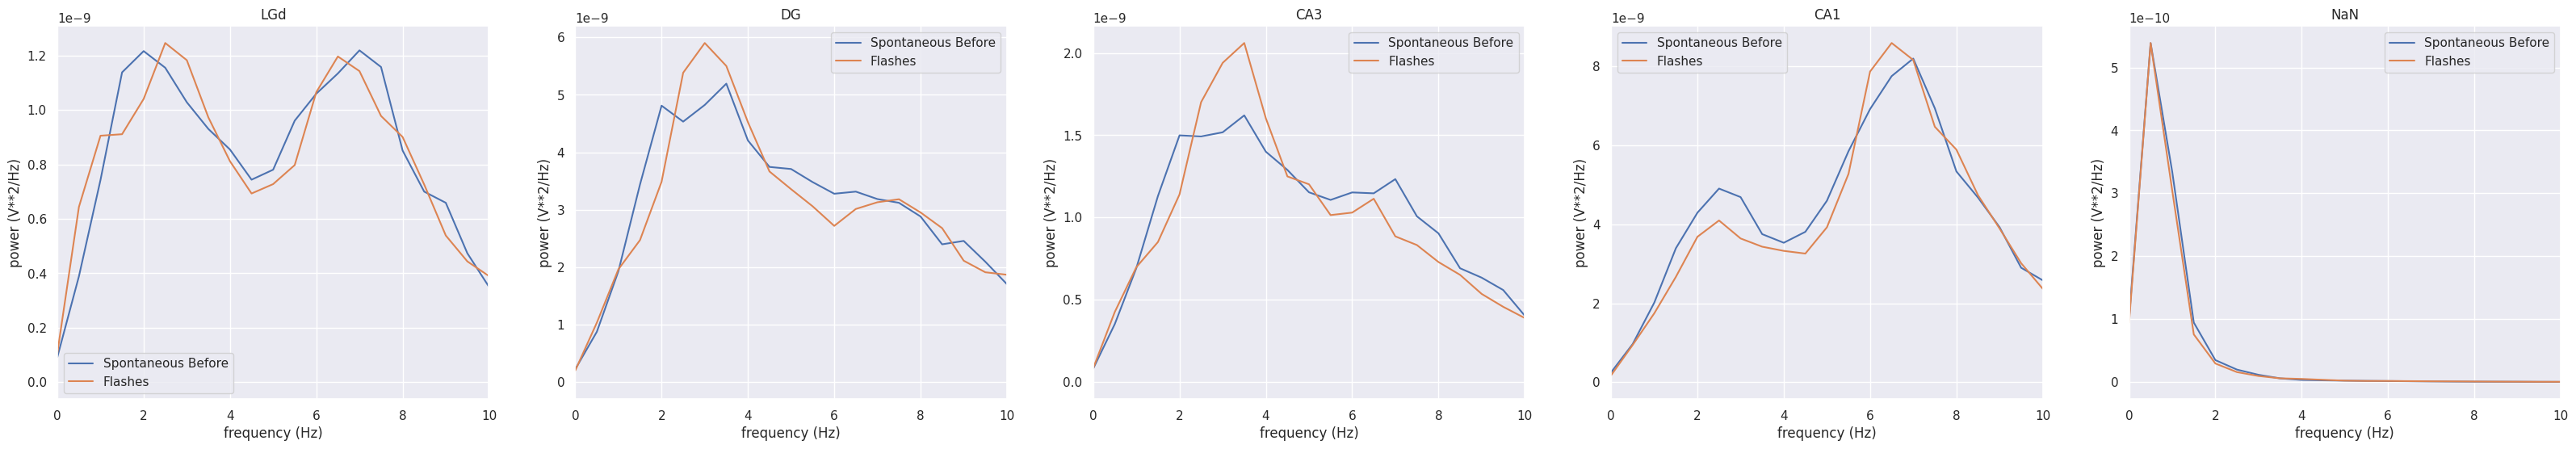

In [114]:
# Areas on VISpm probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISpm_other_areas),figsize=(40,6))

for i in range(len(VISpm_other_areas)):
    welch_psd_plot(axes[i],VISpm_lfp_slice,VISpm_probe_every_area_max_channel[VISpm_other_areas[i]],VISpm_other_areas[i],freq_res=0.5,xlim=[0,10])

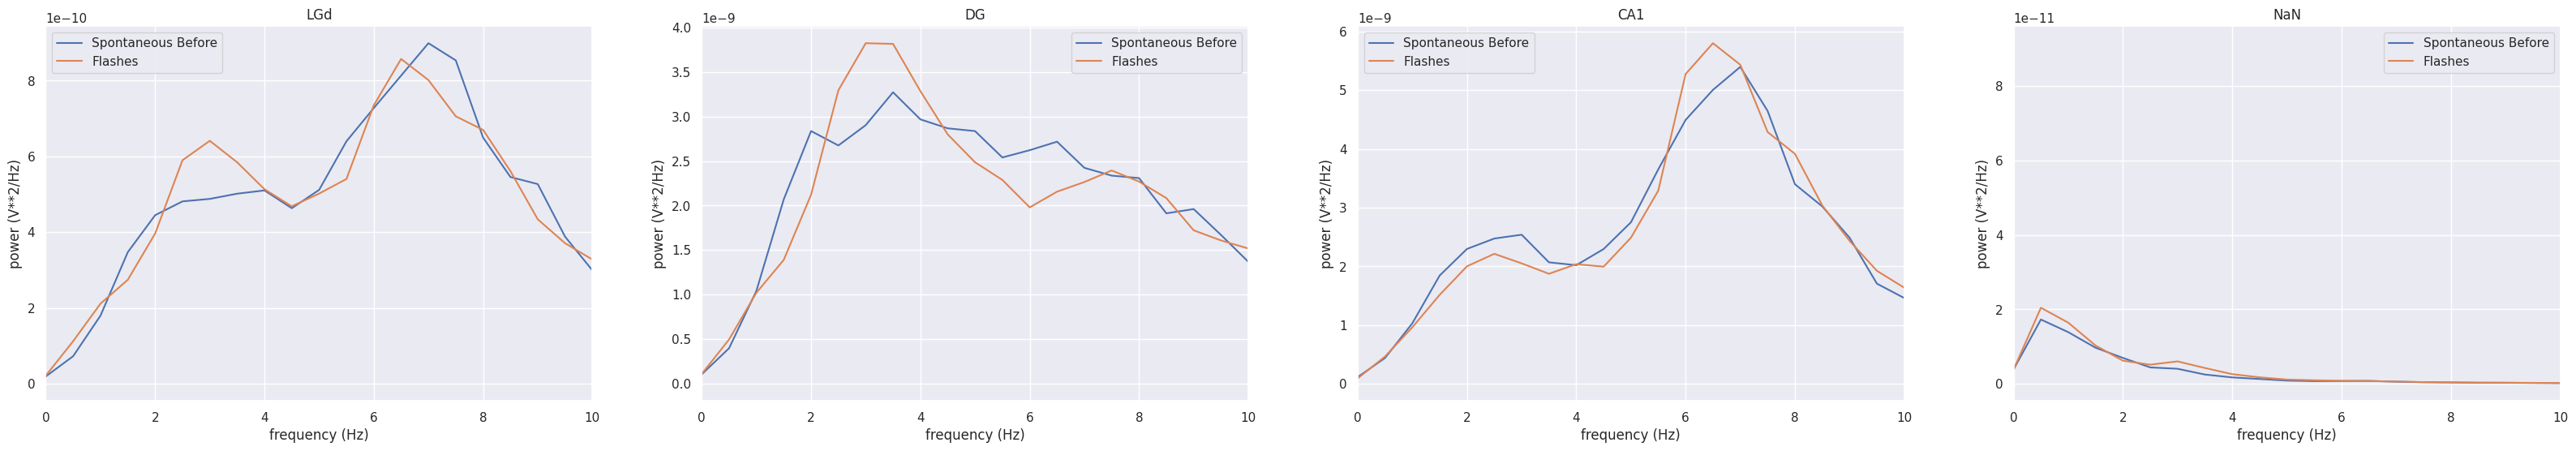

In [115]:
# Areas on VISp probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISp_other_areas),figsize=(40,6))

for i in range(len(VISp_other_areas)):
    welch_psd_plot(axes[i],VISp_lfp_slice,VISp_probe_every_area_max_channel[VISp_other_areas[i]],VISp_other_areas[i],freq_res=0.5,xlim=[0,10])

# 8) Normalise power to maximum power at "spontaneous before" condition

In [119]:
def welch_psd_plot_normalised(ax,lfp_slice,max_channel,title,freq_res=None,xlim=[0,20]):
    f1, psd1 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(spontaneous_before_start_time, spontaneous_before_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)
    f2, psd2 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(flashes_start_time, flashes_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)
    # f3, psd3 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(spontaneous_after_start_time, spontaneous_after_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)

    max_power_at_spontaneous_before = psd1.max()

    ax.plot(f1,psd1/max_power_at_spontaneous_before)
    ax.plot(f2,psd2/max_power_at_spontaneous_before)
    # ax.plot(f3,psd3/max_power_at_spontaneous_before)
    # ax.legend(['Spontaneous Before','Flashes','Spontaneous After'])
    ax.legend(['Spontaneous Before','Flashes'])
    ax.set_xlim(xlim)
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('normalised power (V**2/Hz)')
    ax.set_title(title)

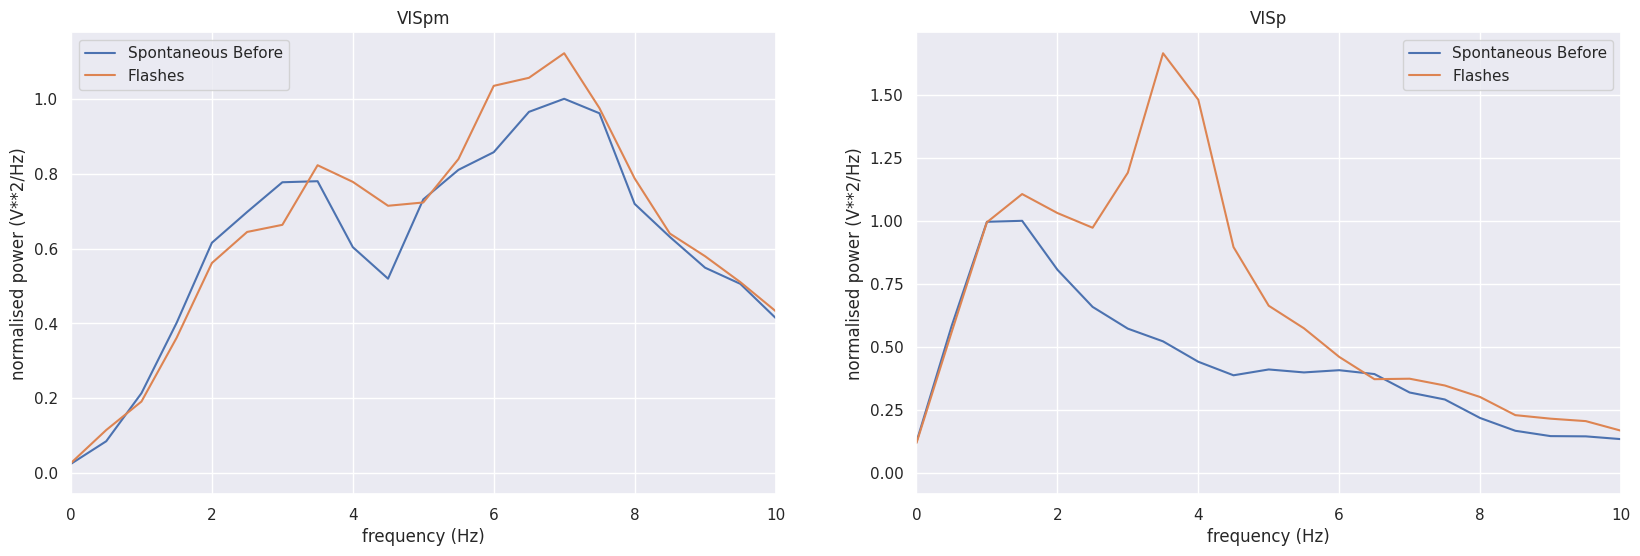

In [120]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

welch_psd_plot_normalised(ax1,VISpm_lfp_slice,VISpm_probe_every_area_max_channel['VISpm'],'VISpm',freq_res=0.5,xlim=[0,10])
welch_psd_plot_normalised(ax2,VISp_lfp_slice,VISp_probe_every_area_max_channel['VISp'],'VISp',freq_res=0.5,xlim=[0,10])

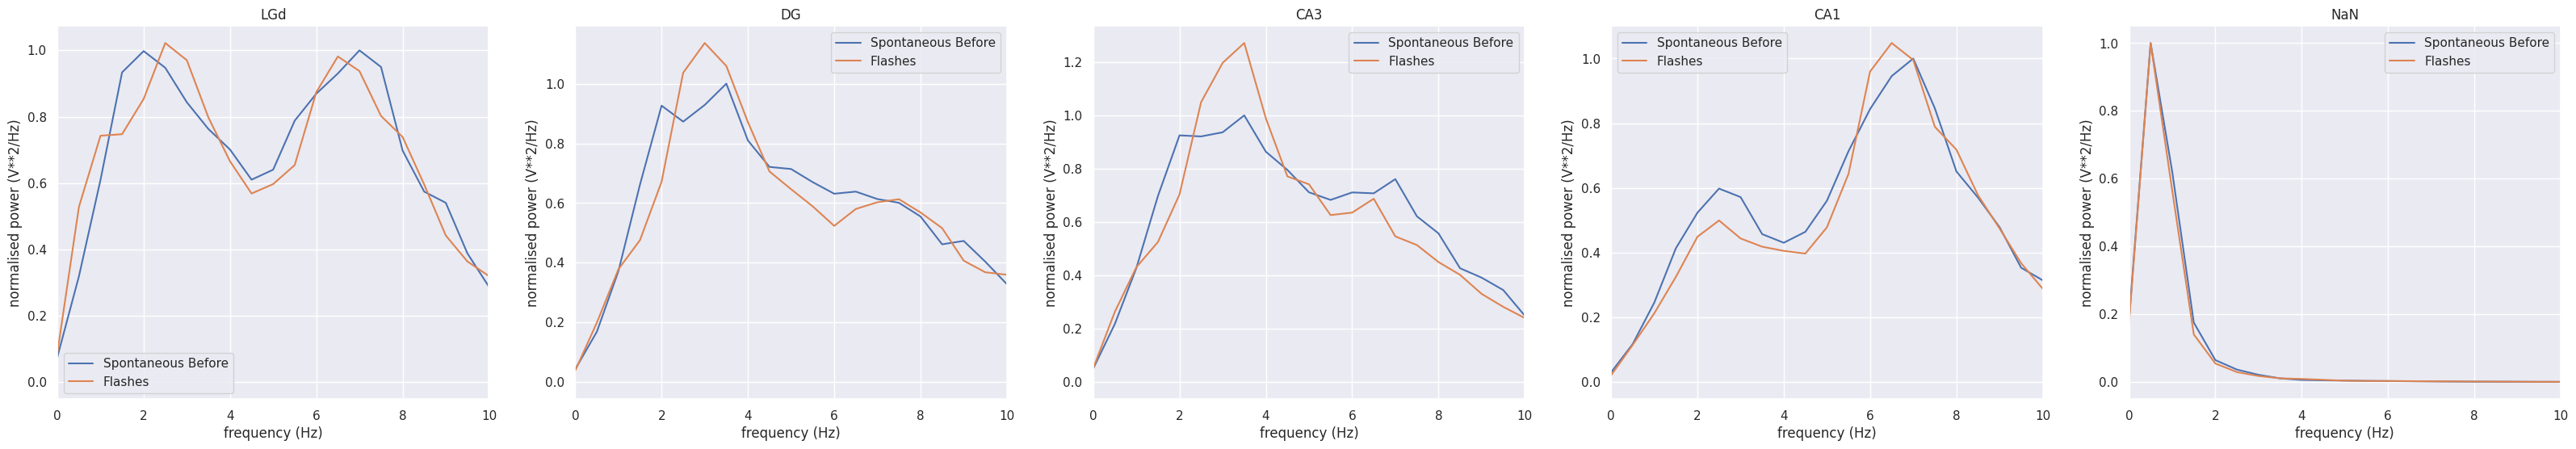

In [121]:
# Areas on VISpm probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISpm_other_areas),figsize=(40,6))

for i in range(len(VISpm_other_areas)):
    welch_psd_plot_normalised(axes[i],VISpm_lfp_slice,VISpm_probe_every_area_max_channel[VISpm_other_areas[i]],VISpm_other_areas[i],freq_res=0.5,xlim=[0,10])

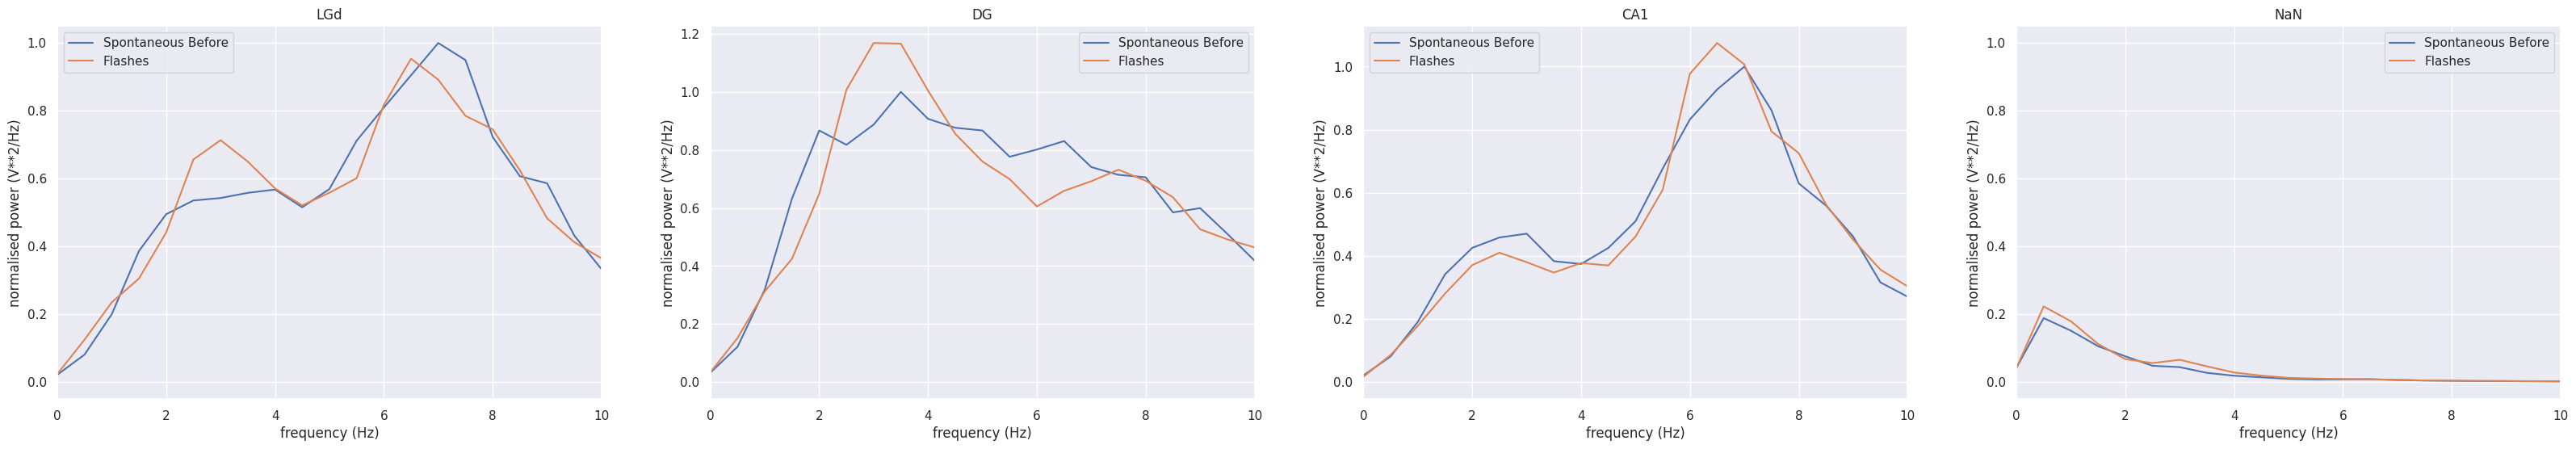

In [122]:
# Areas on VISp probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISp_other_areas),figsize=(40,6))

for i in range(len(VISp_other_areas)):
    welch_psd_plot_normalised(axes[i],VISp_lfp_slice,VISp_probe_every_area_max_channel[VISp_other_areas[i]],VISp_other_areas[i],freq_res=0.5,xlim=[0,10])

# 9) 0-100Hz, 5Hz binning

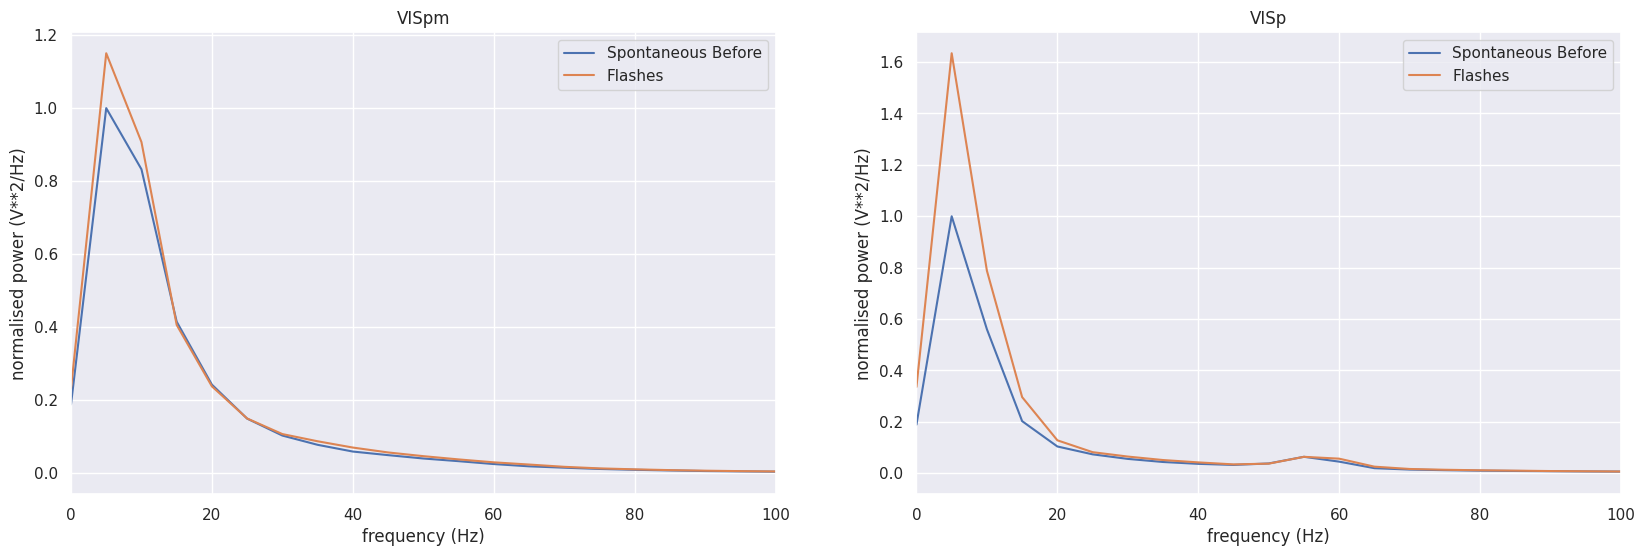

In [124]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

welch_psd_plot_normalised(ax1,VISpm_lfp_slice,VISpm_probe_every_area_max_channel['VISpm'],'VISpm',freq_res=5,xlim=[0,100])
welch_psd_plot_normalised(ax2,VISp_lfp_slice,VISp_probe_every_area_max_channel['VISp'],'VISp',freq_res=5,xlim=[0,100])

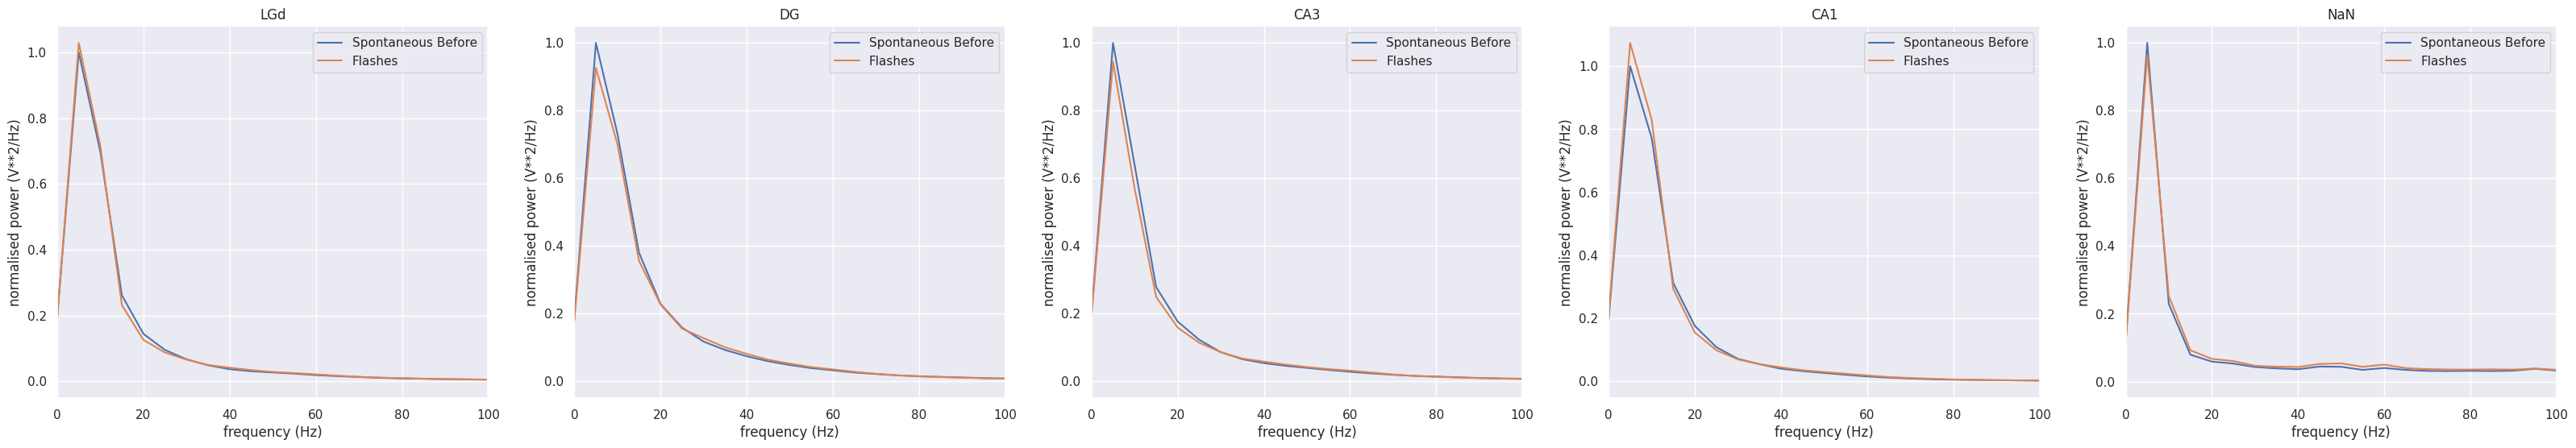

In [126]:
# Areas on VISpm probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISpm_other_areas),figsize=(40,6))

for i in range(len(VISpm_other_areas)):
    welch_psd_plot_normalised(axes[i],VISpm_lfp_slice,VISpm_probe_every_area_max_channel[VISpm_other_areas[i]],VISpm_other_areas[i],freq_res=5,xlim=[0,100])

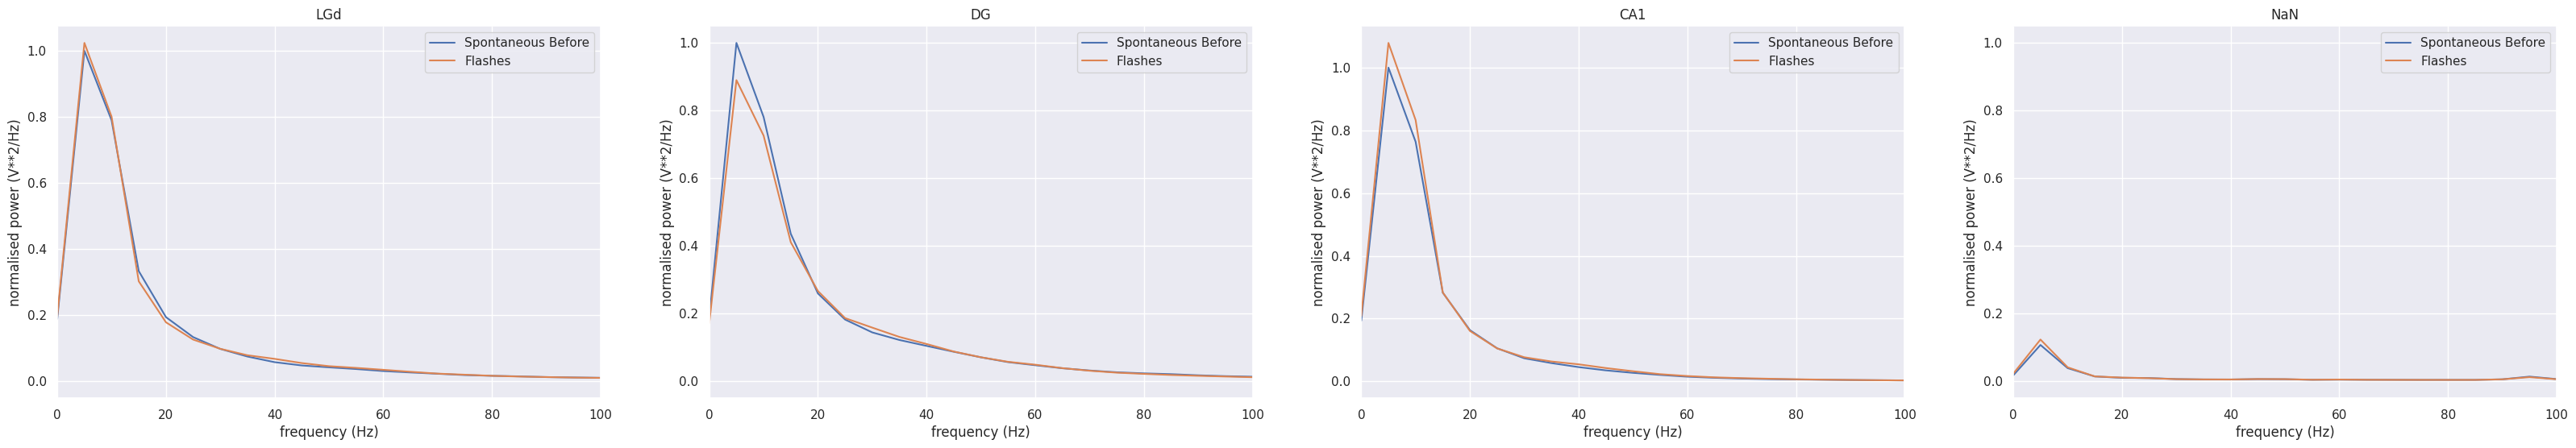

In [125]:
# Areas on VISp probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISp_other_areas),figsize=(40,6))

for i in range(len(VISp_other_areas)):
    welch_psd_plot_normalised(axes[i],VISp_lfp_slice,VISp_probe_every_area_max_channel[VISp_other_areas[i]],VISp_other_areas[i],freq_res=5,xlim=[0,100])